# Proyecto IA - Aprendizaje por Refuerzo
---

## Integrantes
- Andrés Francisco García Rivero
- Jorge Muñoz Rodríguez

### Apartado 1: Implementación mediante Q-Learning

In [238]:
import numpy as np
import mdptoolbox.mdp as mdp
import matplotlib.pyplot as plt

In [239]:
# Leer el mapa
def lee_mapa(fichero):
    with open(fichero,'r') as archivo:
        lineas = archivo.readlines()
    numeros = [float(numero) for numero in lineas[0].split()]
    lineas.pop(0)
    lineas.reverse()
    matriz = []
    for linea in lineas:
        fila = [int(caracter) for caracter in linea.strip()]
        matriz.append(fila)
    return np.array(matriz).T,(int(numeros[0]),int(numeros[1]))

mapa,destino = lee_mapa("map.txt")
print(destino)

(40, 7)


In [240]:
# Parámetros del entorno
n,m = mapa.shape
Perror = 0.1  # Probabilidad de error en el movimiento
print(m,n)

15 51


In [241]:
# Posiciones inicial y final
Pinit = np.random.randint(n),np.random.randint(m)
while mapa[Pinit] == 1 or Pinit == destino:
    Pinit = np.random.randint(n),np.random.randint(m)
Pend = (destino[0], destino[1])

print("Posición inicial:", Pinit)
print("Posición final:", Pend)

Posición inicial: (17, 11)
Posición final: (40, 7)


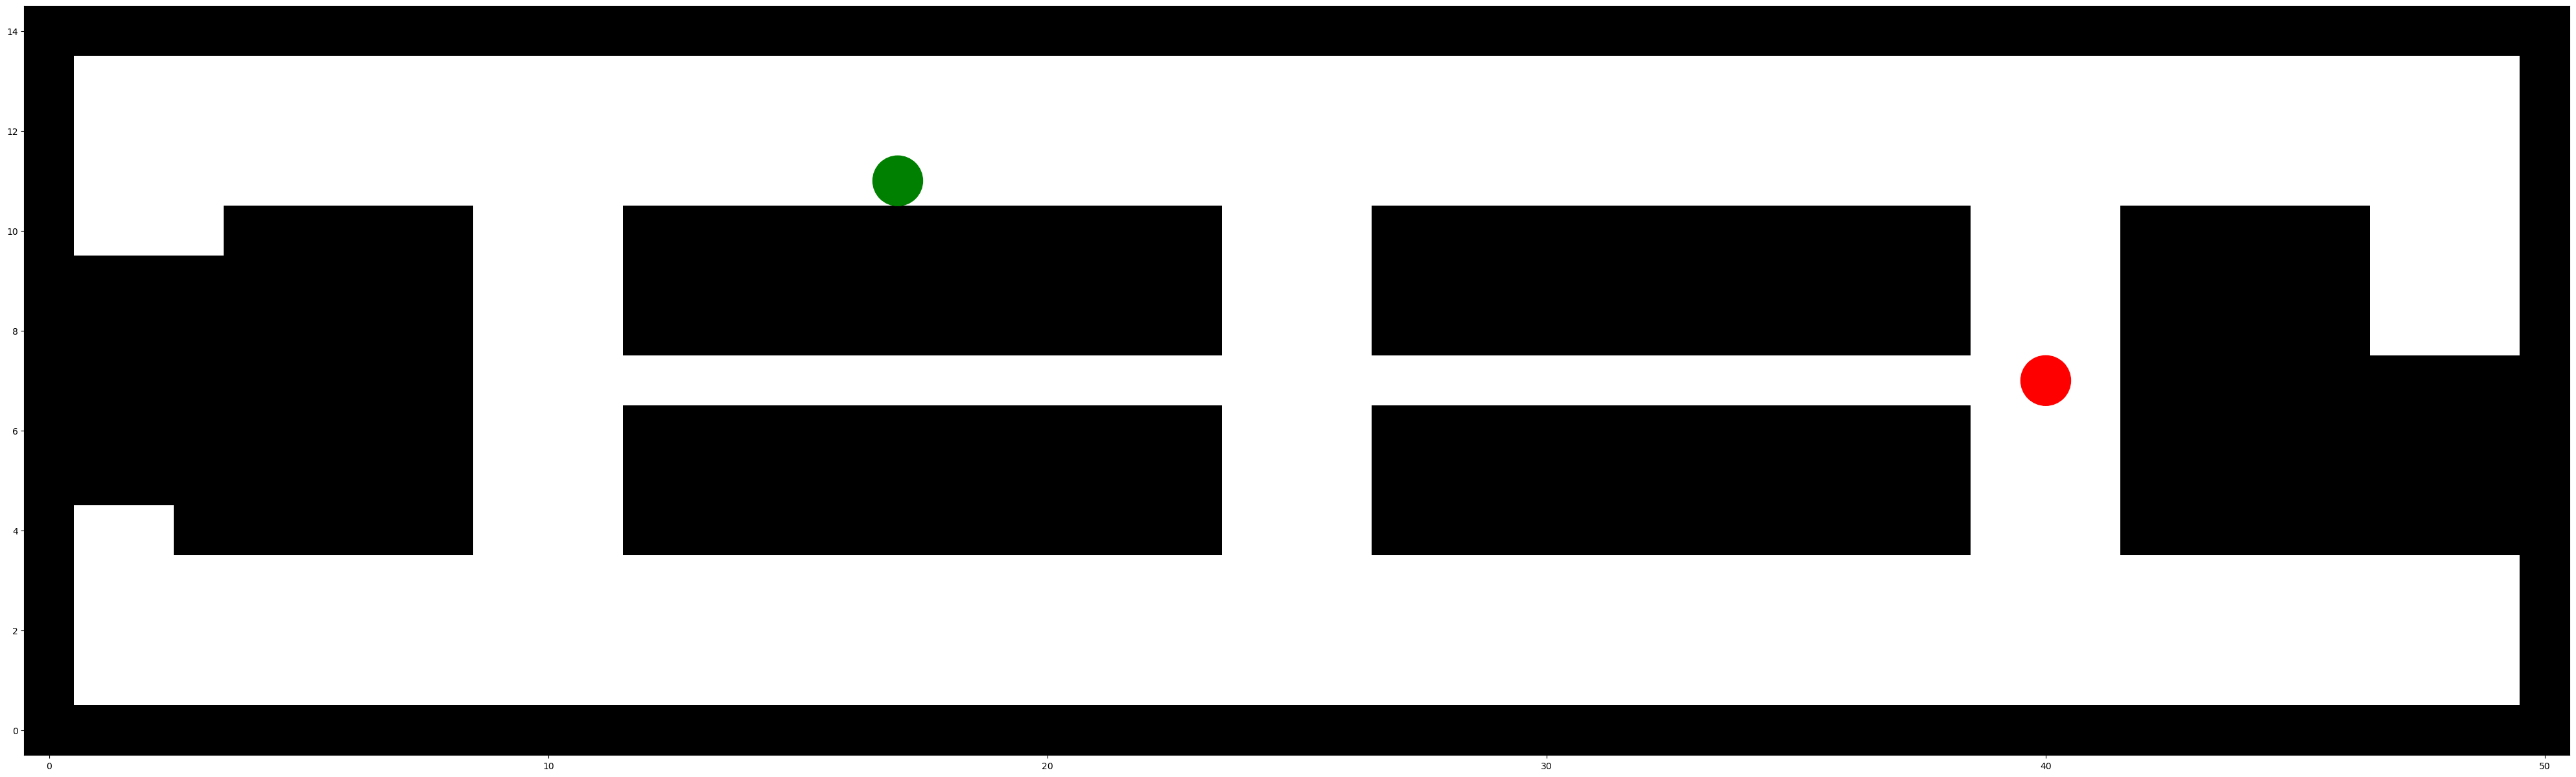

In [242]:
def visualiza_mapa():
    mapa_visual = np.copy(mapa).T
    plt.figure(figsize=(len(mapa_visual[0]), len(mapa_visual)))
    plt.imshow(1-mapa_visual, cmap='gray', interpolation='none')
    plt.xlim(-0.5, len(mapa_visual[0]) - 0.5)
    plt.ylim(-0.5, len(mapa_visual) - 0.5)
    plt.gca().add_patch(plt.Circle(destino,radius = 0.5,edgecolor = 'red', facecolor = 'red'))
    plt.gca().add_patch(plt.Circle(Pinit,radius = 0.5,edgecolor = 'green', facecolor = 'green'))

visualiza_mapa()

In [243]:
# Definición de acciones
acciones = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'wait']
num_acciones = len(acciones)

In [244]:
# Definición de movimientos y errores
movimientos = {
    'N': (-1, 0), 'NE': (-1, 1), 'E': (0, 1), 'SE': (1, 1),
    'S': (1, 0), 'SW': (1, -1), 'W': (0, -1), 'NW': (-1, -1)
}
errores = {
    'N': ['NE', 'NW'], 'NE': ['N', 'E'], 'E': ['NE', 'SE'], 'SE': ['E', 'S'],
    'S': ['SE', 'SW'], 'SW': ['S', 'W'], 'W': ['SW', 'NW'], 'NW': ['N', 'W']
}

In [245]:
# Función de recompensa
K1 = -100
K2 = -1000

def recompensa(s, a, s_prime):
    if mapa[s_prime] == 1: # Si el siguiente estado es un obstáculo
        return K2
    elif a == 'wait' and s_prime != Pend: # Si la acción es esperar y no se ha llegado al objetivo
        return K1
    else:
        return - np.sqrt((s_prime[0] - Pend[0])**2 + (s_prime[1] - Pend[1])**2) # Distancia euclídea al objetivo


In [246]:
def transicion(s, a):
    if mapa[s] == 1:
        return s
    if a == 'wait': # Si la acción es esperar o se ha llegado al objetivo*****
        return s

    if np.random.random() < Perror:
        a_prime = np.random.choice(errores[a])
        mov = movimientos[a_prime]
    else:
        mov = movimientos[a]

    s_prime = (s[0] + mov[0], s[1] + mov[1])
    if s_prime[0] < 0 or s_prime[0] >= n or s_prime[1] < 0 or s_prime[1] >= m:
        return s
    return s_prime

In [247]:
# Creación de las matrices de transición y recompensa
num_states = m * n
T = np.zeros((num_acciones, num_states, num_states))
R = np.zeros((num_states, num_acciones))

In [248]:
# Creación de las matrices de transición y recompensa
num_states = n * m
T = np.zeros((num_acciones, num_states, num_states))
R = np.zeros((num_states, num_acciones))

# Rellenar las matrices T y R
for i in range(n):
    for j in range(m):
        for k, a in enumerate(acciones):
            s = (i, j)
            s_index = i * m + j
            if mapa[s] == 1:
                T[k, s_index, s_index] = 1
                R[s_index, k] = recompensa(s, a, s)
                continue

            s_prime = transicion(s, a)
            s_prime_index = s_prime[0] * m + s_prime[1]
            if 0 <= s_prime_index < num_states:
                T[k, s_index, s_prime_index] = 1 - Perror
                R[s_index, k] = recompensa(s, a, s_prime)

            if a != 'wait':
                for a_prime in errores[a]:
                    s_error = transicion(s, a_prime)
                    s_error_index = s_error[0] * m + s_error[1]
                    if 0 <= s_error_index < num_states:
                        T[k, s_index, s_error_index] += Perror / 2

In [249]:
# Normalizar las filas de la matriz de transición
for k in range(num_acciones):
    for i in range(m*n):
        if T[k, i].sum() > 0:
            T[k, i] /= T[k, i].sum()

In [250]:
# Convertir las matrices a formato compatible con mdptoolbox
T = [T[i] for i in range(num_acciones)]

In [251]:
print(f"T shape: {[t.shape for t in T]}")
print(f"R shape: {R.shape}")

T shape: [(765, 765), (765, 765), (765, 765), (765, 765), (765, 765), (765, 765), (765, 765), (765, 765), (765, 765)]
R shape: (765, 9)


In [252]:
# Implementación de Q-Learning con mdptoolbox
ql = mdp.QLearning(transitions=T, reward=R, discount=0.99, n_iter=300000)
ql.run()

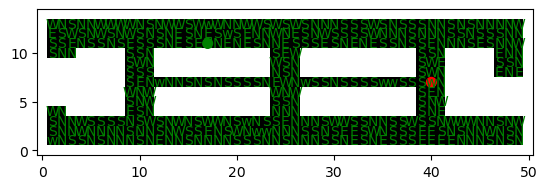

<Figure size 2000x2000 with 0 Axes>

In [279]:
# Mostrar la política aprendida
policy = np.zeros((n, m), dtype=str) 
for i in range(n):
    for j in range(m):
        if mapa[i, j] == 0:
            s_index = i * m + j
            policy[i, j] = acciones[ql.policy[s_index]]

plt.imshow(mapa.T, cmap='gray', origin='lower')
for i in range(n):
    for j in range(m):
        if mapa[i, j] == 0:
            plt.text(i,j, policy[i, j], ha='center', va='center', color='green')
plt.gca().add_patch(plt.Circle(destino,radius = 0.5,edgecolor = 'red', facecolor = 'red'))
plt.gca().add_patch(plt.Circle(Pinit,radius = 0.5,edgecolor = 'green', facecolor = 'green'))
plt.figure(figsize=(20,20))

plt.show()
